# 分子表現 (Molecular Representation)

## 概要

化合物情報に基づく医薬品探索において、分子をどのように表現するかは創薬研究の基礎となる重要な要素です。本ノートブックでは、分子表現の様々な手法について学習し、実際にPythonとRDKitを用いて分子表現を実装します。

## 学習目標

- 分子表現の種類と特徴を理解する
- SMILES記法による分子表現を習得する
- 分子グラフ表現の基本概念を学ぶ
- 分子記述子（Molecular Descriptors）の計算方法を理解する
- 分子フィンガープリントによる類似性検索の原理を学ぶ

## 補助資料

**初心者の方へ**: この内容が難しく感じる場合は、以下の補助資料をご参照ください：

- **[分子表現 初心者ガイド](../molecular-representation-beginner-guide/)**: 基本概念を日常的な例えで解説
- **[分子表現 用語集](../molecular-representation-glossary/)**: 専門用語の分かりやすい説明と参考リンク

これらの資料は、文系出身の方や化学・情報学の予備知識が少ない方でも理解できるよう工夫されています。

## ダウンロード

<a class="link" href="/files/molecular-representation_executed.ipynb" download>📓 実行済みノートブックをダウンロード</a>

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, rdMolDescriptors
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.DataStructs import TanimotoSimilarity
from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = "Noto Sans CJK JP"
sns.set_style("whitegrid")

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


## 1. SMILES記法による分子表現

SMILES (Simplified Molecular Input Line Entry System) は、分子構造を短い文字列で表現する記法です。化学結合と原子を記号で表現し、コンピュータによる分子の処理を可能にします。

In [2]:
# SMILES記法の基本例
molecules = {
    "水 (H2O)": "O",
    "メタン (CH4)": "C",
    "エタノール (C2H5OH)": "CCO",
    "ベンゼン (C6H6)": "c1ccccc1",
    "アスピリン": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "カフェイン": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
}

print("SMILES記法による分子表現の例:")
print("=" * 50)
for name, smiles in molecules.items():
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        print(f"{name:15}: {smiles}")
        print(f"{'分子式':15}: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")
        print(f"{'分子量':15}: {Descriptors.MolWt(mol):.2f}")
        print("-" * 30)
    else:
        print(f"{name}: SMILES解析エラー")

SMILES記法による分子表現の例:
水 (H2O)        : O
分子式            : H2O
分子量            : 18.02
------------------------------
メタン (CH4)      : C
分子式            : CH4
分子量            : 16.04
------------------------------
エタノール (C2H5OH) : CCO
分子式            : C2H6O
分子量            : 46.07
------------------------------
ベンゼン (C6H6)    : c1ccccc1
分子式            : C6H6
分子量            : 78.11
------------------------------
アスピリン          : CC(=O)OC1=CC=CC=C1C(=O)O
分子式            : C9H8O4
分子量            : 180.16
------------------------------
カフェイン          : CN1C=NC2=C1C(=O)N(C(=O)N2C)C
分子式            : C8H10N4O2
分子量            : 194.19
------------------------------


## 2. 分子の2D/3D表示

RDKitを使用して分子構造を視覚化します。これにより、SMILES記法で表現された分子の実際の構造を確認できます。

薬物分子の2D構造:


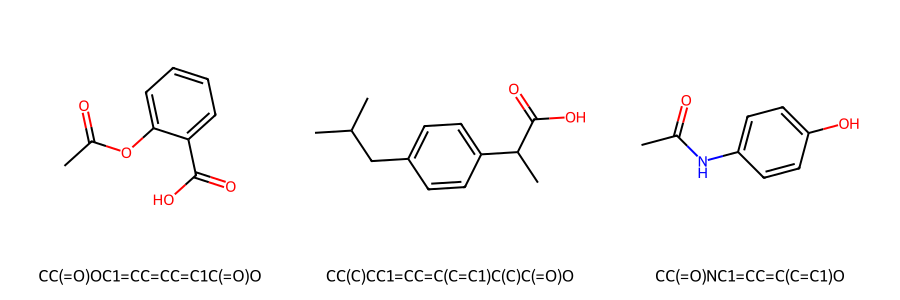

In [3]:
# 分子構造の2D表示
def display_molecules_2d(molecules_dict, mols_per_row=3):
    """分子構造を2Dで表示する関数"""
    mol_objects = []
    legends = []
    
    for name, smiles in molecules_dict.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            mol_objects.append(mol)
            legends.append(f"{name}\n{smiles}")
    
    # 分子構造の描画
    img = Draw.MolsToGridImage(mol_objects, 
                              molsPerRow=mols_per_row,
                              subImgSize=(300, 300),
                              legends=legends)
    return img

# 薬物分子の例
drug_molecules = {
    "アスピリン": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "イブプロフェン": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "パラセタモール": "CC(=O)NC1=CC=C(C=C1)O"
}

print("薬物分子の2D構造:")
display_molecules_2d(drug_molecules)

## 3. 分子記述子 (Molecular Descriptors)

分子記述子は、分子の物理化学的性質を数値で表現したものです。創薬研究では、薬物動態学的性質（ADMET）の予測や薬らしさ（Drug-likeness）の評価に使用されます。

In [4]:
# 分子記述子の計算
def calculate_descriptors(smiles_list, names):
    """分子記述子を計算する関数"""
    descriptors_data = []
    
    for name, smiles in zip(names, smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            desc_dict = {
                '分子名': name,
                'SMILES': smiles,
                '分子量': Descriptors.MolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'HBD': Descriptors.NumHDonors(mol),  # 水素結合ドナー数
                'HBA': Descriptors.NumHAcceptors(mol),  # 水素結合アクセプター数
                'TPSA': Descriptors.TPSA(mol),  # 極性表面積
                'RotBonds': Descriptors.NumRotatableBonds(mol),  # 回転可能結合数
                'RingCount': Descriptors.RingCount(mol),  # 環数
                'AromaticRings': Descriptors.NumAromaticRings(mol)  # 芳香環数
            }
            descriptors_data.append(desc_dict)
    
    return pd.DataFrame(descriptors_data)

# 薬物分子の記述子計算
drug_smiles = list(drug_molecules.values())
drug_names = list(drug_molecules.keys())

df_descriptors = calculate_descriptors(drug_smiles, drug_names)
print("分子記述子の計算結果:")
print("=" * 80)
print(df_descriptors.round(2))

分子記述子の計算結果:
       分子名                         SMILES     分子量  LogP  HBD  HBA   TPSA  \
0    アスピリン       CC(=O)OC1=CC=CC=C1C(=O)O  180.16  1.31    1    3  63.60   
1  イブプロフェン  CC(C)CC1=CC=C(C=C1)C(C)C(=O)O  206.28  3.07    1    1  37.30   
2  パラセタモール          CC(=O)NC1=CC=C(C=C1)O  151.16  1.35    2    2  49.33   

   RotBonds  RingCount  AromaticRings  
0         2          1              1  
1         4          1              1  
2         1          1              1  


## 4. Lipinski's Rule of Five

Lipinski's Rule of Fiveは、経口投与可能な薬物の薬らしさを評価する基準です。以下の4つの条件を満たす化合物は、良好な薬物動態学的性質を持つ可能性が高いとされています：

1. 分子量 ≤ 500 Da
2. LogP ≤ 5
3. 水素結合ドナー数 ≤ 5
4. 水素結合アクセプター数 ≤ 10

In [5]:
def evaluate_lipinski(df):
    """Lipinski's Rule of Fiveによる評価"""
    df_lipinski = df.copy()
    
    # Lipinskiルールの各条件をチェック
    df_lipinski['MW_Pass'] = df_lipinski['分子量'] <= 500
    df_lipinski['LogP_Pass'] = df_lipinski['LogP'] <= 5
    df_lipinski['HBD_Pass'] = df_lipinski['HBD'] <= 5
    df_lipinski['HBA_Pass'] = df_lipinski['HBA'] <= 10
    
    # 総合評価（4つの条件のうち満たした数）
    df_lipinski['Lipinski_Score'] = (
        df_lipinski['MW_Pass'].astype(int) +
        df_lipinski['LogP_Pass'].astype(int) +
        df_lipinski['HBD_Pass'].astype(int) +
        df_lipinski['HBA_Pass'].astype(int)
    )
    
    return df_lipinski

# Lipinskiルールによる評価
df_lipinski = evaluate_lipinski(df_descriptors)

print("Lipinski's Rule of Five による評価:")
print("=" * 60)
for _, row in df_lipinski.iterrows():
    print(f"\n{row['分子名']}:")
    print(f"  分子量: {row['分子量']:.1f} ({'✓' if row['MW_Pass'] else '✗'} ≤500)")
    print(f"  LogP: {row['LogP']:.2f} ({'✓' if row['LogP_Pass'] else '✗'} ≤5)")
    print(f"  HBD: {row['HBD']} ({'✓' if row['HBD_Pass'] else '✗'} ≤5)")
    print(f"  HBA: {row['HBA']} ({'✓' if row['HBA_Pass'] else '✗'} ≤10)")
    print(f"  Lipinskiスコア: {row['Lipinski_Score']}/4")

Lipinski's Rule of Five による評価:

アスピリン:
  分子量: 180.2 (✓ ≤500)
  LogP: 1.31 (✓ ≤5)
  HBD: 1 (✓ ≤5)
  HBA: 3 (✓ ≤10)
  Lipinskiスコア: 4/4

イブプロフェン:
  分子量: 206.3 (✓ ≤500)
  LogP: 3.07 (✓ ≤5)
  HBD: 1 (✓ ≤5)
  HBA: 1 (✓ ≤10)
  Lipinskiスコア: 4/4

パラセタモール:
  分子量: 151.2 (✓ ≤500)
  LogP: 1.35 (✓ ≤5)
  HBD: 2 (✓ ≤5)
  HBA: 2 (✓ ≤10)
  Lipinskiスコア: 4/4


## 5. 分子フィンガープリント

分子フィンガープリントは、分子の構造的特徴をビットベクトルで表現する手法です。分子間の類似性を効率的に計算するために使用されます。

In [6]:
# 分子フィンガープリントの生成と類似性計算
def calculate_molecular_fingerprints(smiles_list, names):
    """分子フィンガープリントを計算し、類似性行列を作成"""
    molecules = []
    valid_names = []
    fingerprints = []
    
    # 分子オブジェクトとフィンガープリントの生成
    for name, smiles in zip(names, smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            molecules.append(mol)
            valid_names.append(name)
            # Morgan フィンガープリント（ECFP4相当）を生成
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fingerprints.append(fp)
    
    # 類似性行列の計算（Tanimoto係数）
    n = len(fingerprints)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            similarity = TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i, j] = similarity
    
    return similarity_matrix, valid_names

# より多くの薬物分子で類似性を計算
extended_drugs = {
    "アスピリン": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "イブプロフェン": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "パラセタモール": "CC(=O)NC1=CC=C(C=C1)O",
    "カフェイン": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "ニコチン": "CN1CCCC1C2=CN=CC=C2",
    "モルヒネ": "CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O"
}

smiles_list = list(extended_drugs.values())
names_list = list(extended_drugs.keys())

similarity_matrix, valid_names = calculate_molecular_fingerprints(smiles_list, names_list)

print("分子フィンガープリントによる類似性行列 (Tanimoto係数):")
print("=" * 60)

# 類似性行列をデータフレームとして表示
df_similarity = pd.DataFrame(similarity_matrix, 
                           index=valid_names, 
                           columns=valid_names)
print(df_similarity.round(3))

分子フィンガープリントによる類似性行列 (Tanimoto係数):
         アスピリン  イブプロフェン  パラセタモール  カフェイン   ニコチン   モルヒネ
アスピリン    1.000    0.195    0.229  0.091  0.128  0.113
イブプロフェン  0.195    1.000    0.189  0.114  0.080  0.094
パラセタモール  0.229    0.189    1.000  0.103  0.091  0.103
カフェイン    0.091    0.114    0.103  1.000  0.128  0.078
ニコチン     0.128    0.080    0.091  0.128  1.000  0.175
モルヒネ     0.113    0.094    0.103  0.078  0.175  1.000


[16:02:56] DEPRECATION WARNING: please use MorganGenerator
[16:02:56] DEPRECATION WARNING: please use MorganGenerator
[16:02:56] DEPRECATION WARNING: please use MorganGenerator
[16:02:56] DEPRECATION WARNING: please use MorganGenerator
[16:02:56] DEPRECATION WARNING: please use MorganGenerator
[16:02:56] DEPRECATION WARNING: please use MorganGenerator


## 6. 類似性のヒートマップ可視化

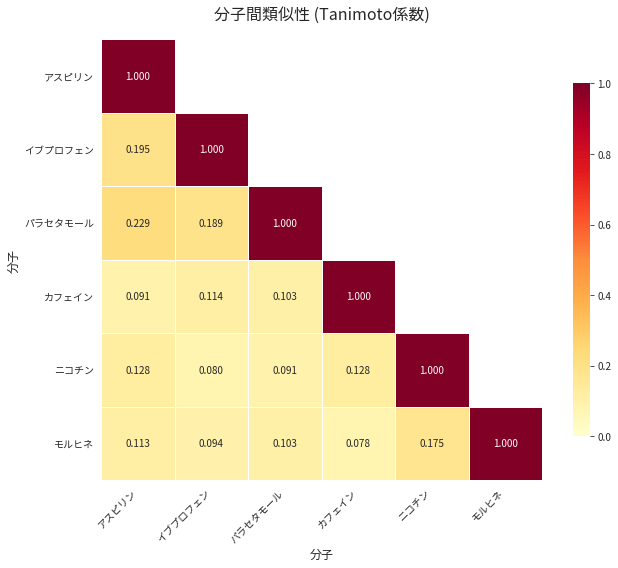


最も類似している分子ペア (上位5位):
    分子1     分子2      類似度
  アスピリン パラセタモール 0.228571
  アスピリン イブプロフェン 0.195122
イブプロフェン パラセタモール 0.189189
   ニコチン    モルヒネ 0.174603
  アスピリン    ニコチン 0.127660


In [7]:
# ヒートマップによる類似性の可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)

sns.heatmap(df_similarity, 
            annot=True, 
            cmap='YlOrRd', 
            vmin=0, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            fmt='.3f',
            mask=mask)

plt.title('分子間類似性 (Tanimoto係数)', fontsize=16, pad=20)
plt.xlabel('分子', fontsize=12)
plt.ylabel('分子', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 最も類似している分子ペアを特定
similarity_pairs = []
n = len(valid_names)
for i in range(n):
    for j in range(i+1, n):
        similarity_pairs.append({
            '分子1': valid_names[i],
            '分子2': valid_names[j],
            '類似度': similarity_matrix[i, j]
        })

df_pairs = pd.DataFrame(similarity_pairs)
df_pairs = df_pairs.sort_values('類似度', ascending=False)

print("\n最も類似している分子ペア (上位5位):")
print("=" * 50)
print(df_pairs.head().to_string(index=False))

## 7. 記述子の分布と相関分析

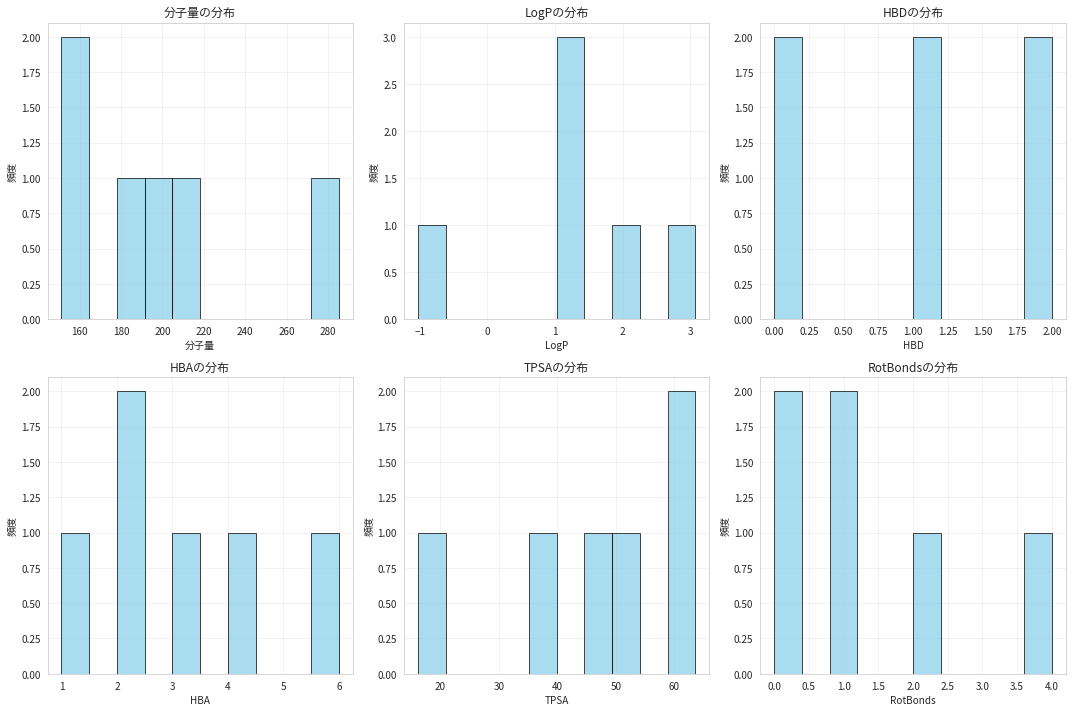

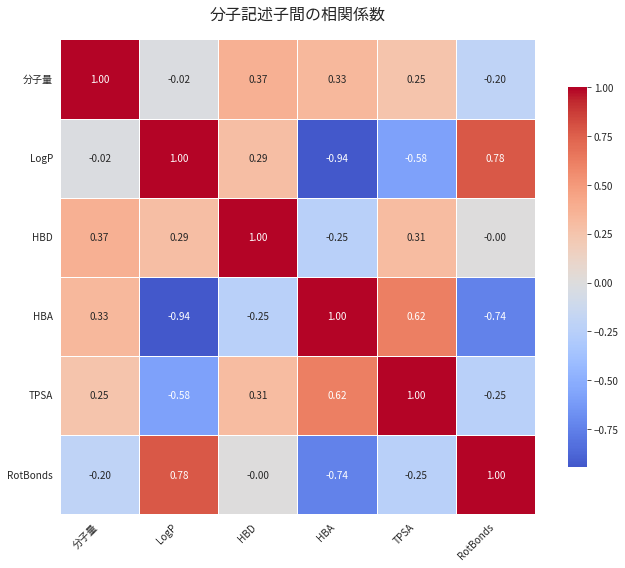

記述子間の相関分析:
強い正の相関 (r > 0.7):
  LogP - RotBonds: 0.775

強い負の相関 (r < -0.7):
  LogP - HBA: -0.942
  HBA - RotBonds: -0.743


In [8]:
# より多くの分子の記述子を計算
plt.rcParams['font.family'] = "Noto Sans CJK JP"
extended_smiles = list(extended_drugs.values())
extended_names = list(extended_drugs.keys())

df_extended = calculate_descriptors(extended_smiles, extended_names)

# 記述子の分布を可視化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

descriptors_to_plot = ['分子量', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds']

for i, desc in enumerate(descriptors_to_plot):
    axes[i].hist(df_extended[desc], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{desc}の分布', fontsize=12)
    axes[i].set_xlabel(desc, fontsize=10)
    axes[i].set_ylabel('頻度', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 記述子間の相関行列
correlation_matrix = df_extended[descriptors_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            fmt='.2f')

plt.title('分子記述子間の相関係数', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("記述子間の相関分析:")
print("=" * 40)
print("強い正の相関 (r > 0.7):")
for i in range(len(descriptors_to_plot)):
    for j in range(i+1, len(descriptors_to_plot)):
        corr = correlation_matrix.iloc[i, j]
        if corr > 0.7:
            print(f"  {descriptors_to_plot[i]} - {descriptors_to_plot[j]}: {corr:.3f}")

print("\n強い負の相関 (r < -0.7):")
for i in range(len(descriptors_to_plot)):
    for j in range(i+1, len(descriptors_to_plot)):
        corr = correlation_matrix.iloc[i, j]
        if corr < -0.7:
            print(f"  {descriptors_to_plot[i]} - {descriptors_to_plot[j]}: {corr:.3f}")

## まとめ

本ノートブックでは、分子表現の基本的な手法について学習しました：

### 主要なポイント

1. **SMILES記法**: 分子構造を文字列で表現する標準的な方法
2. **分子記述子**: 分子の物理化学的性質を数値化
3. **Lipinski's Rule of Five**: 薬らしさを評価する重要な基準
4. **分子フィンガープリント**: 構造類似性を効率的に計算する手法
5. **類似性検索**: 新薬候補化合物の探索に応用

### 創薬における応用

- **バーチャルスクリーニング**: 大規模化合物ライブラリから候補化合物を選別
- **QSAR (Quantitative Structure-Activity Relationship)**: 構造と活性の相関解析
- **薬物動態予測**: ADMET性質の計算による薬物候補の評価
- **化学空間の探索**: 新規骨格の発見と最適化

### 次のステップ

1. 化合物データベースの活用
2. 機械学習による活性予測
3. ファルマコフォア解析
4. 構造最適化手法

In [9]:
# 最終的な統計情報の表示
print("分子表現学習の統計情報:")
print("=" * 40)
print(f"解析した分子数: {len(df_extended)}")
print(f"計算した記述子数: {len(descriptors_to_plot)}")
print(f"平均分子量: {df_extended['分子量'].mean():.1f} ± {df_extended['分子量'].std():.1f}")
print(f"平均LogP: {df_extended['LogP'].mean():.2f} ± {df_extended['LogP'].std():.2f}")
print(f"Lipinskiルール完全適合: {len(df_lipinski[df_lipinski['Lipinski_Score'] == 4])}/{len(df_lipinski)} 分子")

print("\n学習が完了しました！")

分子表現学習の統計情報:
解析した分子数: 6
計算した記述子数: 6
平均分子量: 196.6 ± 47.9
平均LogP: 1.29 ± 1.33
Lipinskiルール完全適合: 3/3 分子

学習が完了しました！


## 補助資料

### ダウンロード

- <a class="link" href="/files/molecular_representation_executed.ipynb" download>実行済みJupyter Notebook (.ipynb)</a>